In [1]:
# Kellem Deuitch 20176047
# adapted from https://www.analyticsvidhya.com/blog/2021/05/sms-spam-detection-using-lstm-a-hands-on-guide/

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import keras
from nltk.corpus import stopwords
import collections
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# read in dataset
data = pd.read_csv("spam_ham_dataset.csv", encoding='latin')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
# remove unnamed column, null data
data = data.drop(columns=['Unnamed: 0'])
data = data.dropna(axis=0)
data.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
data['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

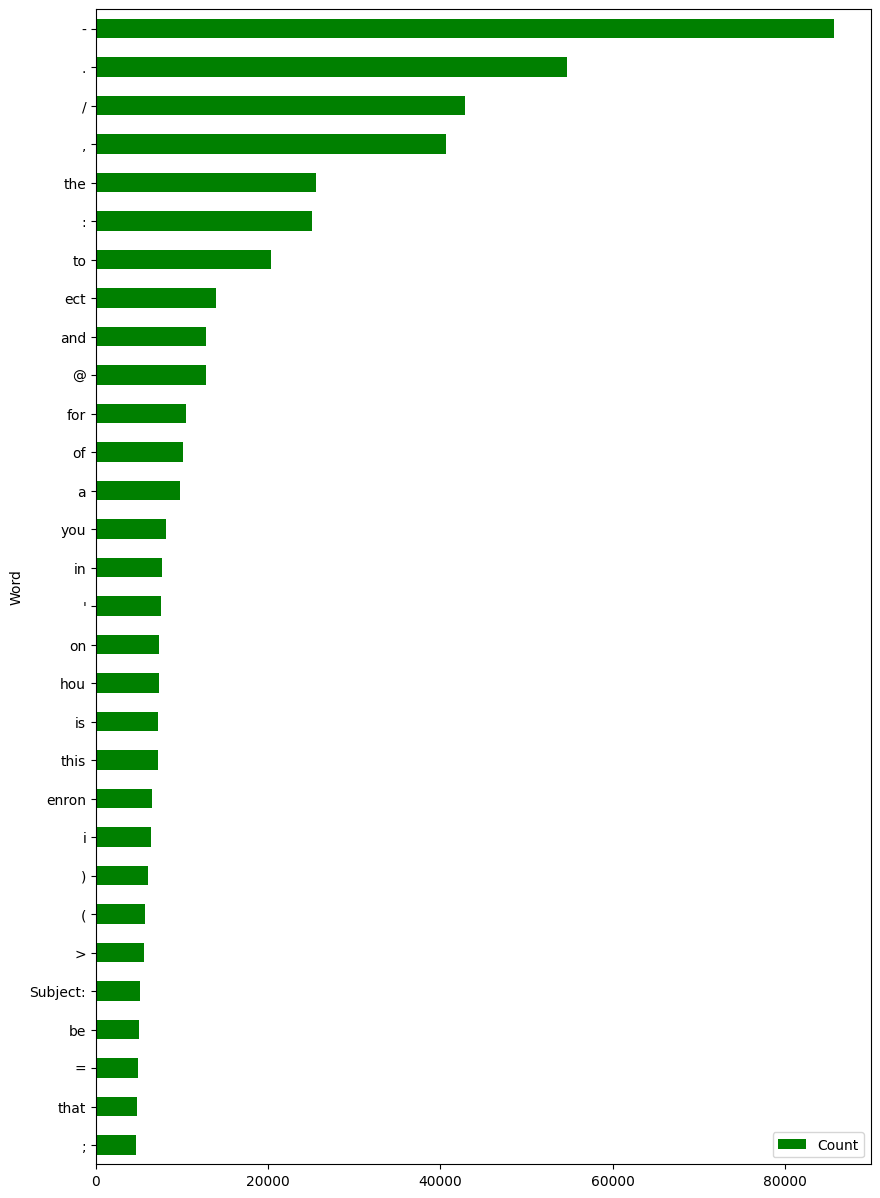

In [6]:
# plots most common 30 words in the dataset
def word_count_plot(data):
    # finding words along with count
     word_counter = collections.Counter([word for sentence in data for word in sentence.split()])
     most_count = word_counter.most_common(30) # 30 most common words
     # sorted data frame
     most_count = pd.DataFrame(most_count, columns=["Word", "Count"]).sort_values(by="Count")
     most_count.plot.barh(x = "Word", y = "Count", color="green", figsize=(10, 15))
        
word_count_plot(data['text'])

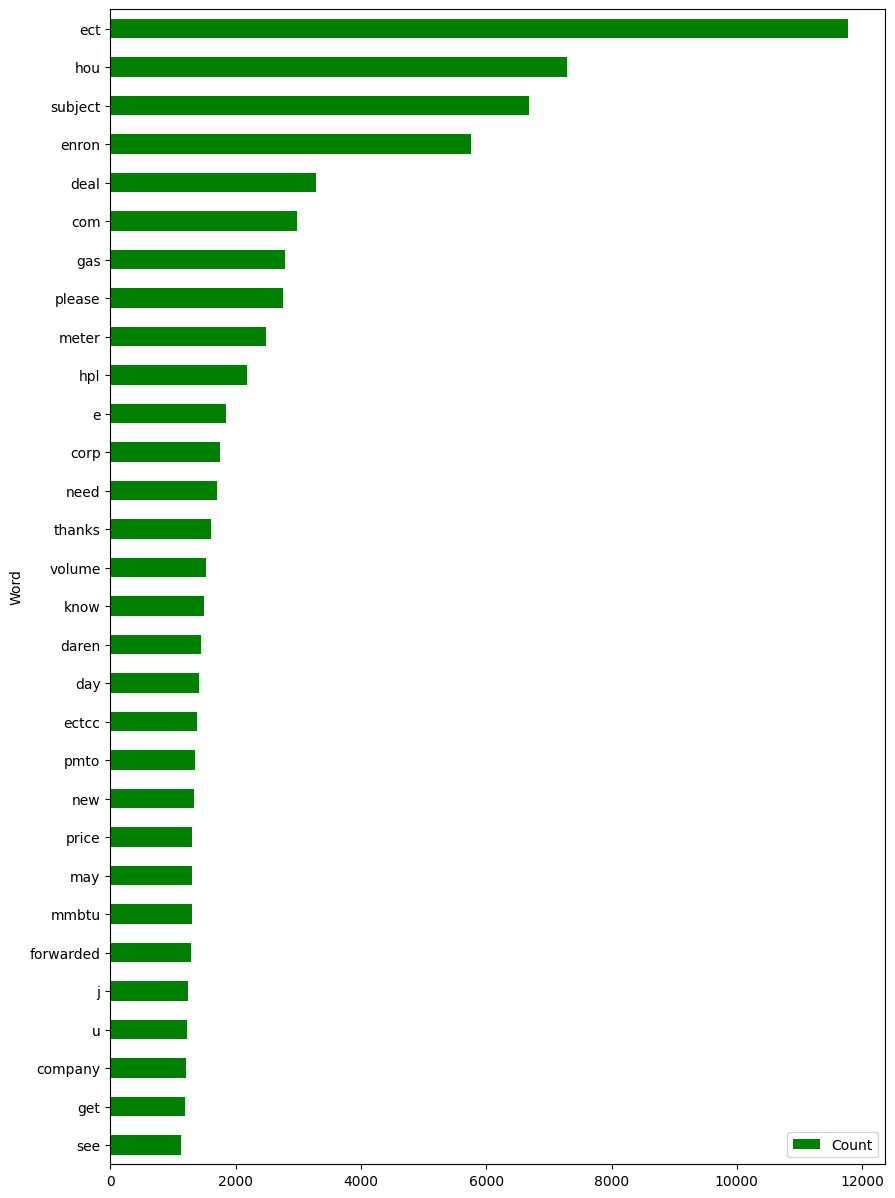

In [7]:
# perform email stripping
lem = WordNetLemmatizer()
def preprocess(data):
    # lowercase only
    mail = data.lower()
    # remove all special characters
    mail = re.sub("[^a-z ]", "", mail)
    mail = mail.split()
    # remove filler words, extract base of each word
    mail = [lem.lemmatize(word) for word in mail if not word in set(stopwords.words('english'))]
    mail = " ".join(mail)
    return mail
    
x = data['text'].apply(preprocess)
word_count_plot(x)

In [8]:
# encode labels for prediction comparison
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(data['label'])
y.shape

(5171,)

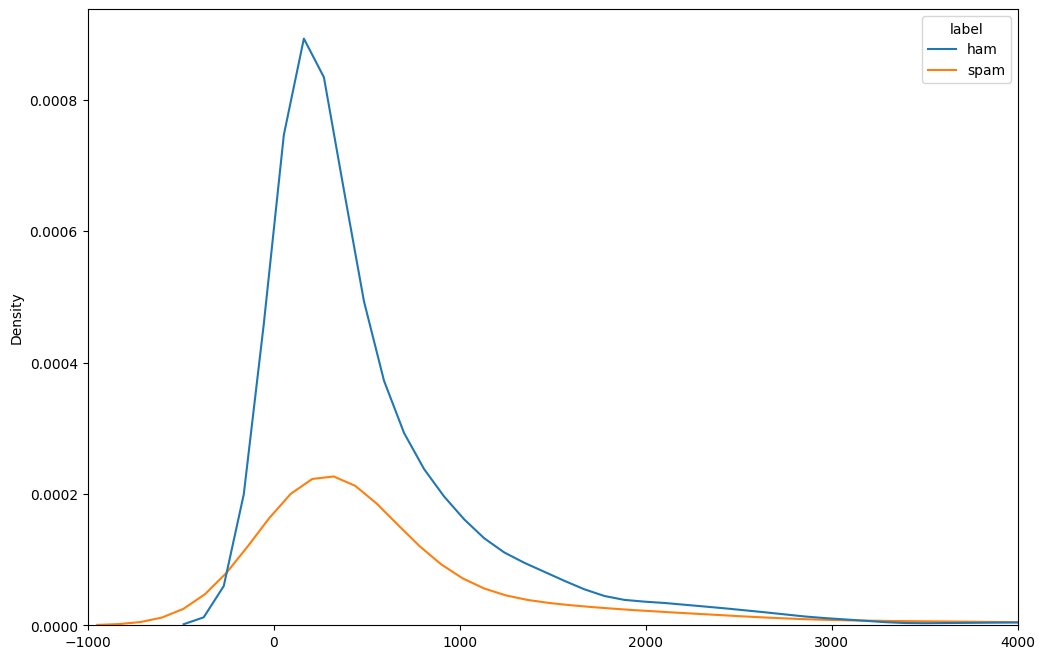

In [9]:
# plot email length densities for spam & ham
length = [len(i) for i in x]
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=length,
    hue=data["label"]
)
plt.xlim(-1000, 4000)
plt.show()

In [10]:
# tokenize text into frequency vectors
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
text2seq = tokenizer.texts_to_sequences(x)

In [11]:
# define maximum email size
maxseq = 200
print(maxseq)
padded = pad_sequences(text2seq, maxlen=maxseq, padding='pre')

# turn into a dataframe for easier parsing
extracted = pd.DataFrame(data=padded)
extracted.head()

200


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,898,14600,2438,7,302,40,409,1173,3204,1020
1,0,0,0,0,0,0,0,0,0,0,...,10,54,139,30,37,59,1497,35,1497,35
2,1149,7353,39,16,39,104,2302,8604,4983,151,...,318,1393,318,7354,318,1632,1939,83,968,1968
3,0,0,0,0,0,0,0,0,0,0,...,14607,23904,23905,1351,23906,23907,2946,23908,14608,23909
4,0,0,0,0,0,0,0,0,0,0,...,122,32,27,16,10694,1665,348,2515,5,13


In [12]:
# create training and testing sets
x_train, x_test, y_train, y_test = train_test_split(extracted, y, random_state=42, test_size=0.2)

In [13]:
# define vocabulary size for model input
TOT_SIZE = len(tokenizer.word_index) + 1

# generate model
lstm = Sequential()
lstm.add(Embedding(TOT_SIZE, 64, input_length=maxseq))
lstm.add(LSTM(64, dropout=0.4))
'''lstm.add(Dropout(0.4))
lstm.add(Dense(20, activation='relu'))
lstm.add(Dropout(0.3))'''
lstm.add(Dense(1, activation='sigmoid'))

# compile the model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           4016000   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,049,089
Trainable params: 4,049,089
Non-trainable params: 0
_________________________________________________________________


In [14]:
# train the model
lstm.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

Epoch 1/10
26/26 [==============================] - 14s 477ms/step - loss: 0.6077 - accuracy: 0.6971 - val_loss: 0.4794 - val_accuracy: 0.7162
Epoch 2/10
26/26 [==============================] - 8s 303ms/step - loss: 0.2826 - accuracy: 0.8625 - val_loss: 0.1695 - val_accuracy: 0.9626
Epoch 3/10
26/26 [==============================] - 6s 248ms/step - loss: 0.1454 - accuracy: 0.9655 - val_loss: 0.1414 - val_accuracy: 0.9541
Epoch 4/10
26/26 [==============================] - 7s 269ms/step - loss: 0.0950 - accuracy: 0.9695 - val_loss: 0.0981 - val_accuracy: 0.9734
Epoch 5/10
26/26 [==============================] - 7s 273ms/step - loss: 0.0518 - accuracy: 0.9891 - val_loss: 0.0824 - val_accuracy: 0.9746
Epoch 6/10
26/26 [==============================] - 7s 271ms/step - loss: 0.0332 - accuracy: 0.9921 - val_loss: 0.0695 - val_accuracy: 0.9771
Epoch 7/10
26/26 [==============================] - 8s 294ms/step - loss: 0.0202 - accuracy: 0.9955 - val_loss: 0.0676 - val_accuracy: 0.9771
Epoch

In [15]:
# evaluate the model
y_pred = lstm.predict(x_test)
y_pred = (y_pred > 0.5)
print("Test Score:{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

33/33 [==============================] - 2s 33ms/step
Test Score:97.68%
Confusion Matrix:
 [[728  14]
 [ 10 283]]
